In [1]:
%matplotlib inline
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
wk_dir = os.getcwd()

### Download competition data

In [ ]:
%cd ../data/kg

In [ ]:
%%bash
kg config -c state-farm-distracted-driver-detection
kg download
mkdir statefarm
mv *.zip statefarm/
unzip -q statefarm/imgs.zip
unzip -q statefarm/sample_submission.csv.zip
unzip -q statefarm/driver_imgs_list.csv.zip

In [ ]:
%cd statefarm
data_dir = os.getcwd()

In [ ]:
%%bash
tree -d

In [ ]:
%ls test | wc -l

In [ ]:
%%bash
mkdir test/unknown
echo test/*.jpg | xargs mv -t test/unknown

In [ ]:
%ls test/unknown | head -5

In [ ]:
%%bash
cd train
for dir in *;
do
    echo -n $dir "- "
    ls $dir | wc -l
done
cd ..
# 2,000 - 2,400 images in each trn directory

In [ ]:
%ls train/c0 | head -5

In [ ]:
%cat sample_submission.csv | head -5

Kaggle says what they want is a list of probabilities for each class, so the data can look like:

```
img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_0.jpg,1,0,0,0,0,...,0
img_1.jpg,0.3,0.1,0.6,0,...,0
```

In [ ]:
%cat driver_imgs_list.csv | head -5

Why do we need this data?

### Create validation and sample sets

In [ ]:
%%bash
mkdir valid
for i in {0..9};
do 
    mkdir valid/c$i
done
mkdir models

mkdir sample
mkdir sample/train
for i in {0..9};
do
    mkdir sample/train/c$i
done
mkdir sample/valid
for i in {0..9};
do
    mkdir sample/valid/c$i
done
mkdir sample/test
mkdir sample/test/unknown
mkdir sample/models

In [ ]:
from shutil import copyfile

Copy files from `train/` to `sample/train/`

In [ ]:
for i in range(10):
    c = "c" + str(i) + "/"
    %cd $data_dir/train/$c
    g = glob("*.jpg")
    shuf = np.random.permutation(g)
    for i in range(100):
        copyfile(shuf[i], data_dir + "/sample/train/" + c + shuf[i])

Copy files from `test/` to `sample/test/`

In [ ]:
%cd $data_dir/test/unknown
g = glob("*.jpg")
shuf = np.random.permutation(g)
for i in range(4000):
    copyfile(shuf[i], data_dir + "/sample/test/unknown/" + shuf[i])

Create validation set:

In [ ]:
for i in range(10):
    c = "c" + str(i) + "/"
    %cd $data_dir/train/$c
    g = glob("*.jpg")
    shuf = np.random.permutation(g)
    for i in range(400):
        os.rename(shuf[i], data_dir + "/valid/" + c + shuf[i])

Create validation set for sample:

In [ ]:
for i in range(10):
    c = "c" + str(i) + "/"
    %cd $data_dir/sample/train/$c
    g = glob("*.jpg")
    shuf = np.random.permutation(g)
    for i in range(20):
        os.rename(shuf[i], data_dir + "/sample/valid/" + c + shuf[i])

### Grab our data/batches/classes/labels

In [3]:
data_dir = wk_dir + "/../data/kg/statefarm/sample/"
# data_dir = wk_dir + "/../data/kg/statefarm/"
%cd $data_dir

/home/ubuntu/courses/deeplearning1/data/kg/statefarm/sample


In [4]:
trn_dir = data_dir + "/train/"
val_dir = data_dir + "/valid/"
test_dir = data_dir + "/test/"
model_dir = data_dir + "/models/"

In [5]:
bsz = 8

**Note:** We're probably sacrificing resolution here - we didn't check the original image size.

In [ ]:
%%time
trn_data = get_data(trn_dir)
val_data = get_data(val_dir)

In [ ]:
save_array(model_dir + "trn_data.bc", trn_data)
save_array(model_dir + "val_data.bc", val_data)

In [6]:
trn_data = load_array(model_dir + "trn_data.bc")
val_data = load_array(model_dir + "val_data.bc")

In [34]:
trn_batches = get_batches(trn_dir, batch_size=bsz)
val_batches = get_batches(val_dir, batch_size=bsz)

trn_classes = trn_batches.classes
val_classes = val_batches.classes

trn_labels = onehot(trn_classes)
val_labels = onehot(val_classes)

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [35]:
indices = val_batches.class_indices

### Use built-in VGG methods (16-33-43)

In [8]:
%%time
vgg = Vgg16()
vgg.finetune(trn_batches)
vgg.fit(trn_batches, val_batches, nb_epoch=3)

Epoch 1/3
800/800 [==============================] - 25s - loss: 4.0672 - acc: 0.1650 - val_loss: 2.2237 - val_acc: 0.2750
Epoch 2/3
800/800 [==============================] - 25s - loss: 2.6890 - acc: 0.3325 - val_loss: 1.5019 - val_acc: 0.4950
Epoch 3/3
800/800 [==============================] - 25s - loss: 2.1711 - acc: 0.4312 - val_loss: 1.5910 - val_acc: 0.5000
CPU times: user 1min 48s, sys: 20.5 s, total: 2min 8s
Wall time: 1min 31s


200/200 [==============================] - 5s     
[[ 2  0  1  3  1  0  2  3  0  8]
 [ 0  3  0  3  0  5  2  3  1  3]
 [ 0  0 13  0  0  0  3  1  2  1]
 [ 0  0  0 15  1  0  3  1  0  0]
 [ 0  1  0  8  7  0  1  2  0  1]
 [ 0  0  0  2  1 13  2  1  0  1]
 [ 0  1  5  2  0  0  8  2  1  1]
 [ 0  0  0  0  0  0  1 18  0  1]
 [ 0  0  3  1  0  1  3  2  6  4]
 [ 0  0  1  2  0  1  0  0  1 15]]


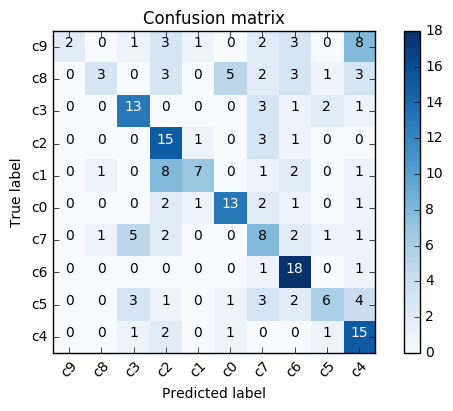

In [9]:
preds = vgg.model.predict_classes(val_data, batch_size=bsz)
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, indices)

Accuracy is like 40-60%. But it's also sample data?

### Functions for updating models

In [10]:
def fit_model(model, trn_batches, val_batches, nb_epoch=1):
    model.fit_generator(
        trn_batches,
        samples_per_epoch=trn_batches.N,
        
        nb_epoch=nb_epoch,
        
        validation_data=val_batches,
        nb_val_samples=val_batches.N
    )

def fit_epochs(model, trn_batches, val_batches, nb_epoch, run):
    for i in range(nb_epoch):
        fit_model(model, trn_batches, val_batches, nb_epoch=1)
        model.save_weights(model_dir + "finetune{}{}.h5".format(run, str(i)))

### Retrain only last layer (15-33-42)

In [11]:
vgg = Vgg16()
model = vgg.model

model.pop()

for layer in model.layers:
    layer.trainable = False

opt = Adam(lr=0.001) 

model.add(
    Dense(10, activation="softmax")
)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fit_epochs(model, trn_batches, val_batches, nb_epoch=3, run="lastlayer")

Epoch 1/1
800/800 [==============================] - 25s - loss: 3.8869 - acc: 0.1575 - val_loss: 1.8967 - val_acc: 0.3800
Epoch 1/1
800/800 [==============================] - 25s - loss: 2.5606 - acc: 0.3375 - val_loss: 1.6770 - val_acc: 0.4550
Epoch 1/1
800/800 [==============================] - 25s - loss: 2.1603 - acc: 0.4288 - val_loss: 1.1677 - val_acc: 0.6300


200/200 [==============================] - 5s     
[[ 9  1  0  1  4  0  2  1  0  2]
 [ 0 10  0  2  0  2  4  1  0  1]
 [ 0  0 14  0  0  1  2  1  2  0]
 [ 0  1  0 12  3  0  3  0  0  1]
 [ 0  0  0  3 16  1  0  0  0  0]
 [ 0  1  0  0  2 16  1  0  0  0]
 [ 0  3  3  1  0  2 11  0  0  0]
 [ 1  1  0  0  0  0  1 16  0  1]
 [ 0  1  3  0  0  1  6  0  9  0]
 [ 0  0  1  1  1  1  1  0  2 13]]


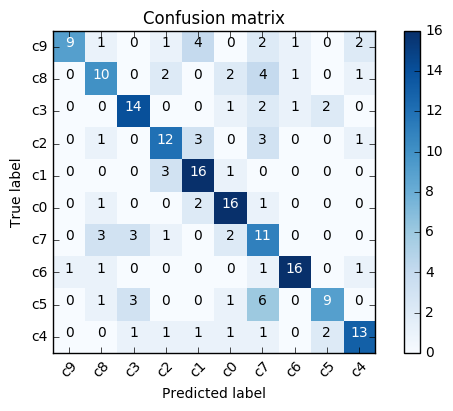

In [12]:
preds = model.predict_classes(val_data, batch_size=bsz)
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, indices)

Actually looks like it performs slightly better than VGG.finetune? It shouldn't though - it should perform the same as all the steps are the same.

### Retrain multiple layers (48-53-56)

Don't skip the step of fine-tuning just the final layer first, since otherwise you'll have one layer with random weights, which will cause the other layers to quickly move a long way from their optimized imagenet weights.

**What does this mean?**

In [16]:
layers = model.layers
first_dense_idx = [index for index, layer in enumerate(layers) if type(layer) is Dense][0]
for layer in layers[first_dense_idx:]:
    layer.trainable = True

Looks like having a non-zero value in the model.summary params column means 'trainable'.

In [17]:
K.set_value(opt.lr, 0.01)

In [23]:
fit_epochs(model, trn_batches, val_batches, nb_epoch=3, run="alldense")

Epoch 1/1
800/800 [==============================] - 25s - loss: 1.9424 - acc: 0.4838 - val_loss: 1.3870 - val_acc: 0.5950
Epoch 1/1
800/800 [==============================] - 25s - loss: 1.7947 - acc: 0.5363 - val_loss: 1.3524 - val_acc: 0.5600
Epoch 1/1
800/800 [==============================] - 25s - loss: 1.6032 - acc: 0.5650 - val_loss: 1.1882 - val_acc: 0.6150


200/200 [==============================] - 5s     
[[ 9  0  0  2  2  0  3  1  0  3]
 [ 0 10  0  2  0  1  5  0  0  2]
 [ 0  0 13  0  0  0  5  0  1  1]
 [ 0  0  0 16  2  0  2  0  0  0]
 [ 0  1  0  6 10  1  0  1  0  1]
 [ 0  1  0  1  1 16  1  0  0  0]
 [ 0  4  4  1  0  0 10  0  0  1]
 [ 0  0  0  0  0  0  1 17  0  2]
 [ 0  1  2  0  0  1  6  0  9  1]
 [ 1  0  0  4  0  0  1  0  1 13]]


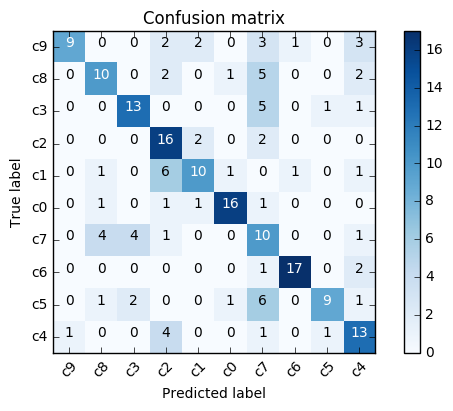

In [24]:
preds = model.predict_classes(val_data, batch_size=bsz)
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, indices)

Training accuracy has gone from 15-35-45 using just VGG.finetune/single Dense to 48-53-56, which is nice (but we're also doing more epochs).

**Since we haven't changed our architecture, there's no need to re-compile the model - instead, we just set the learning rate.**

Ok but the last few layers are still set to trainable though.

### What else can we do?

1. Augment data
2. Retrain Conv layers
3. Add BatchNorm layers (how to do this with VGG? Insert?)
4. Reduce Dropout values (again, how do you do this?)
5. Ensemble model

### Augment data (38-41-46-47-56-64-61)

In [26]:
gen = image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
trn_batches = gen.flow(trn_data, trn_labels, batch_size=bsz)
val_batches = gen.flow(val_data, val_labels, batch_size=bsz)

In [31]:
K.set_value(opt.lr, 0.001)
fit_epochs(model, trn_batches, val_batches, nb_epoch=1, run="augmentedlr001")

Epoch 1/1
800/800 [==============================] - 25s - loss: 3.0449 - acc: 0.3850 - val_loss: 2.3104 - val_acc: 0.4200


In [32]:
K.set_value(opt.lr, 0.0001)
fit_epochs(model, trn_batches, val_batches, nb_epoch=3, run="augmentedlr0001")

Epoch 1/1
800/800 [==============================] - 25s - loss: 2.7051 - acc: 0.4175 - val_loss: 2.0462 - val_acc: 0.4050
Epoch 1/1
800/800 [==============================] - 25s - loss: 2.3756 - acc: 0.4662 - val_loss: 1.6745 - val_acc: 0.5200
Epoch 1/1
800/800 [==============================] - 25s - loss: 2.3849 - acc: 0.4725 - val_loss: 1.6884 - val_acc: 0.5250


Not too much improvement - is this because we're using new data? 38-41-46-47. Last time was 48-53-56 - let's try three more.

In [37]:
fit_epochs(model, trn_batches, val_batches, nb_epoch=3, run="augmentedlr0001")

Epoch 1/1
800/800 [==============================] - 25s - loss: 1.7231 - acc: 0.5625 - val_loss: 1.2208 - val_acc: 0.6150
Epoch 1/1
800/800 [==============================] - 25s - loss: 1.4454 - acc: 0.6488 - val_loss: 1.3731 - val_acc: 0.6000
Epoch 1/1
800/800 [==============================] - 25s - loss: 1.4721 - acc: 0.6138 - val_loss: 0.9133 - val_acc: 0.6950


Yes - we're getting in the 56-64-61 range.

### Retrain Conv layers (60-63-65-68-67-65)

In [38]:
for layer in layers[12:]: 
    layer.trainable=True

In [39]:
K.set_value(opt.lr, 0.001)
fit_epochs(model, trn_batches, val_batches, nb_epoch=3, run="retrainedconv")

Epoch 1/1
800/800 [==============================] - 25s - loss: 1.4910 - acc: 0.6063 - val_loss: 1.0966 - val_acc: 0.6650
Epoch 1/1
800/800 [==============================] - 25s - loss: 1.4582 - acc: 0.6312 - val_loss: 1.0823 - val_acc: 0.6650
Epoch 1/1
800/800 [==============================] - 25s - loss: 1.3004 - acc: 0.6525 - val_loss: 1.0026 - val_acc: 0.7150


60-63-65! Nice! Let's keep going for a bit.

In [40]:
fit_epochs(model, trn_batches, val_batches, nb_epoch=3, run="retrainedconv")

Epoch 1/1
800/800 [==============================] - 25s - loss: 1.1745 - acc: 0.6838 - val_loss: 0.9475 - val_acc: 0.7100
Epoch 1/1
800/800 [==============================] - 25s - loss: 1.2264 - acc: 0.6787 - val_loss: 0.9497 - val_acc: 0.6750
Epoch 1/1
800/800 [==============================] - 25s - loss: 1.2552 - acc: 0.6575 - val_loss: 0.9392 - val_acc: 0.7450


### Let's take a break to see if we can submit predictions

In [104]:
%cd $data_dir

/home/ubuntu/courses/deeplearning1/data/kg/statefarm/sample


In [110]:
test_dir = test_dir + "/../../test/"
model_dir = model_dir + "/../../models/"

In [ ]:
%%time
test_batches = get_batches(test_dir, batch_size=bsz)
filenames = test_batches.filenames

test_data = get_data(test_dir)

Found 79726 images belonging to 1 classes.
Found 79726 images belonging to 1 classes.


In [ ]:
save_array(model_dir + "test_data.bc", test_data)

In [ ]:
test_data = load_array(model_dir + "test_data.bc")

In [ ]:
%%time
preds = model.predict(test_data, batch_size=bsz)

In [ ]:
save_array(model_dir + "preds.bc", preds)

In [ ]:
preds = load_array(model_dir + "preds.bc")

In [ ]:
ids = np.array([f[8:] for f in filenames])
ids = np.expand_dims(ids, 1)

In [ ]:
subm = np.concatenate([ids, preds], axis=1)

Soooo
1. Do the filenames even match up with preds?
2. Are the columns even in order???

In [ ]:
subm.shape

In [ ]:
%cd $wk_dir
submission_file_name = "submission1.csv"
np.savetxt(
    submission_file_name, 
    subm,
    fmt="%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s",
    header="img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9", 
    comments=""
)

In [101]:
from IPython.display import FileLink

In [ ]:
%cd $wk_dir
FileLink(submission_file_name)

### Add BatchNorm layers

### Reduce Dropout values

### Ensemble model